In [15]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform=transforms.Compose([
    transforms.ToTensor()
])

In [3]:
fashionmnist_train = FashionMNIST(root='data', train=True, download=True, transform=transform)
loader = DataLoader(fashionmnist_train, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16866924.80it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268687.07it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4947528.22it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10038250.58it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [5]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [6]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [11]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data

def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data

Starting epoch 0...
g_loss: 1.709449291229248, d_loss: 0.8282288312911987


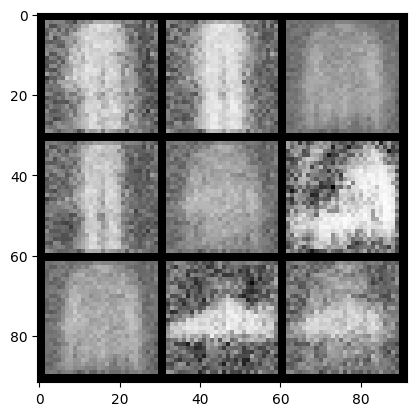

Starting epoch 1...
g_loss: 1.2923222780227661, d_loss: 1.2864625453948975


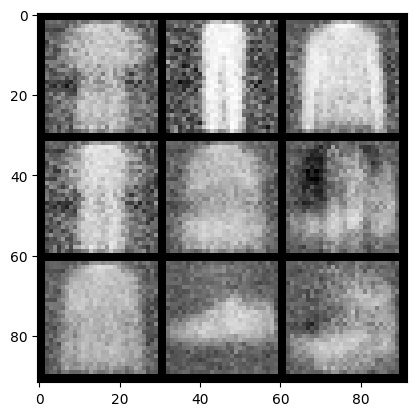

Starting epoch 2...
g_loss: 1.3104432821273804, d_loss: 0.9395623207092285


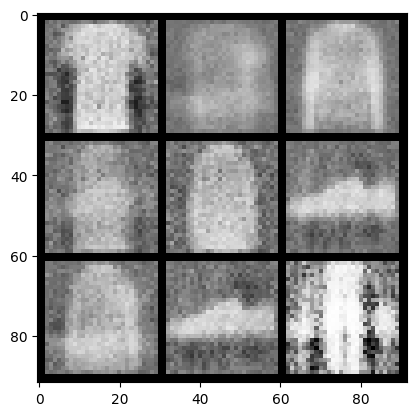

Starting epoch 3...
g_loss: 1.6608002185821533, d_loss: 0.8764856457710266


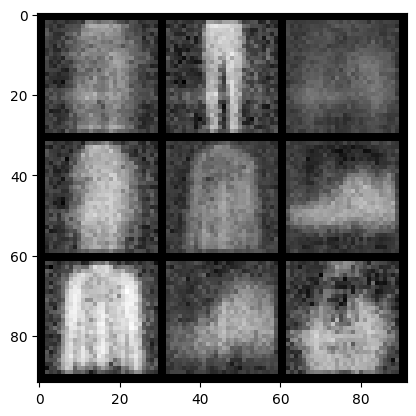

Starting epoch 4...
g_loss: 1.3194515705108643, d_loss: 1.1945583820343018


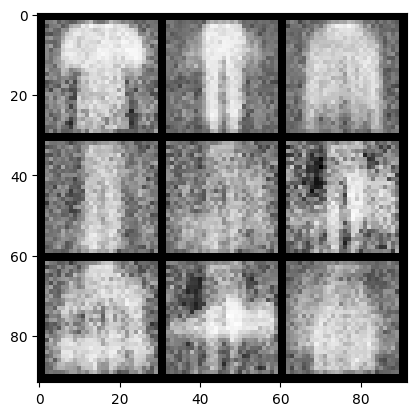

Starting epoch 5...
g_loss: 1.1631503105163574, d_loss: 1.1556763648986816


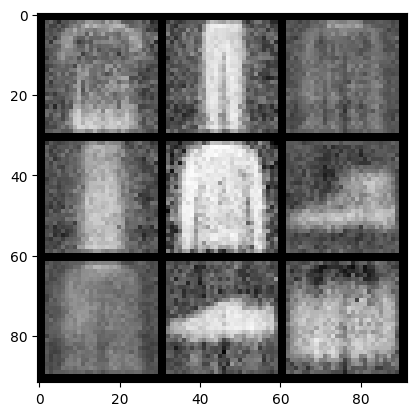

Starting epoch 6...
g_loss: 1.079681158065796, d_loss: 1.4146747589111328


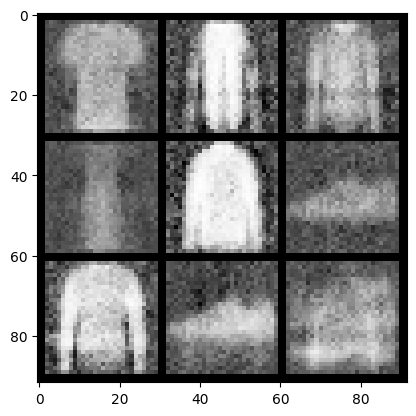

Starting epoch 7...
g_loss: 1.7052993774414062, d_loss: 1.2314772605895996


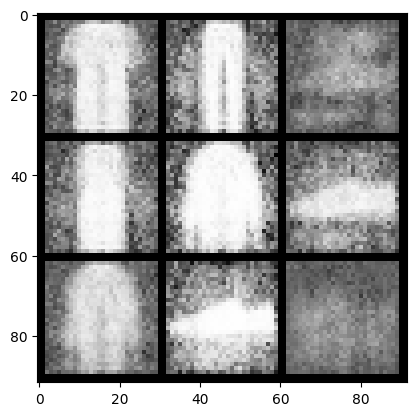

Starting epoch 8...
g_loss: 1.282667636871338, d_loss: 0.910196840763092


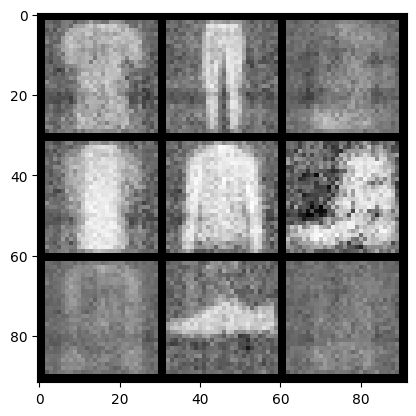

Starting epoch 9...
g_loss: 1.2016521692276, d_loss: 0.9908575415611267


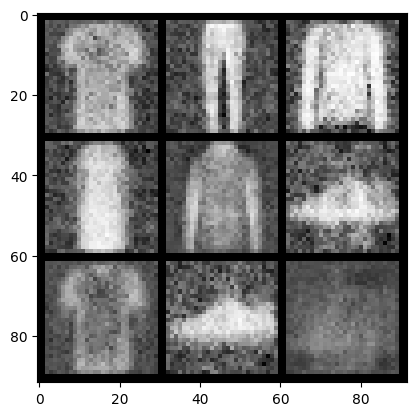

Starting epoch 10...
g_loss: 1.295790433883667, d_loss: 1.0249836444854736


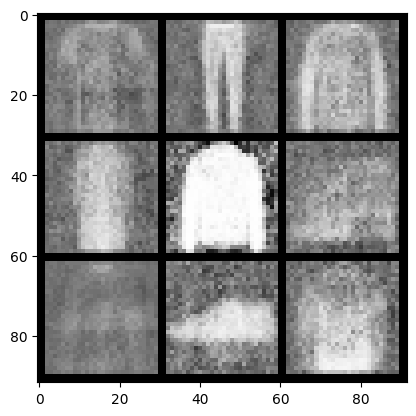

Starting epoch 11...
g_loss: 1.1960608959197998, d_loss: 1.070805311203003


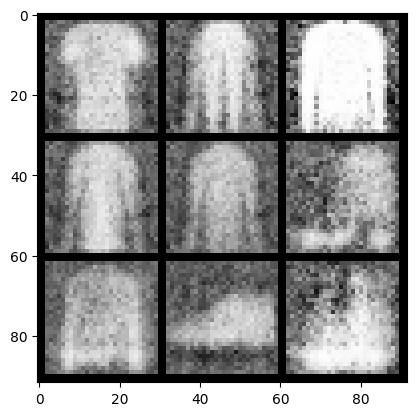

Starting epoch 12...
g_loss: 1.5051894187927246, d_loss: 1.2319210767745972


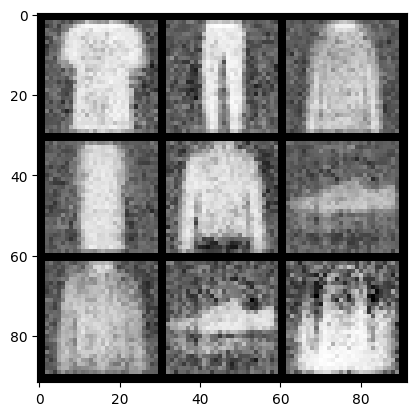

Starting epoch 13...
g_loss: 1.3938605785369873, d_loss: 0.9462367296218872


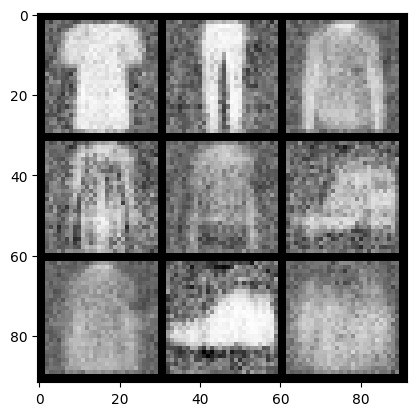

Starting epoch 14...
g_loss: 1.602294921875, d_loss: 1.158165454864502


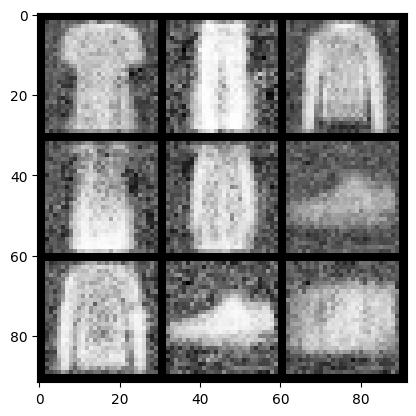

Starting epoch 15...
g_loss: 1.291414737701416, d_loss: 0.922559380531311


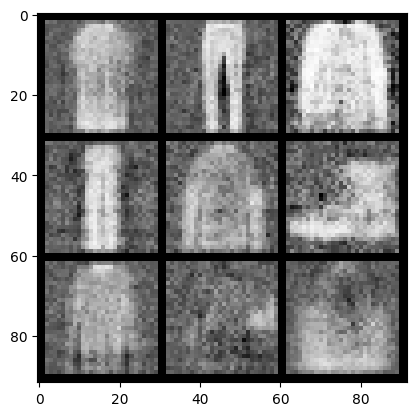

Starting epoch 16...
g_loss: 1.3815172910690308, d_loss: 1.157753348350525


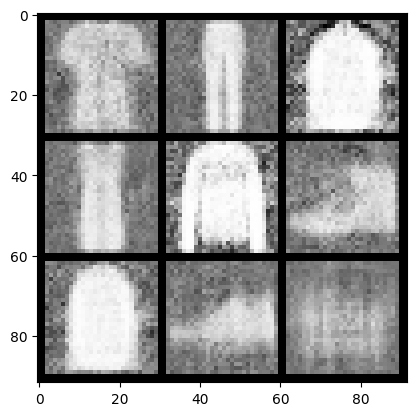

Starting epoch 17...
g_loss: 1.5216333866119385, d_loss: 1.3458819389343262


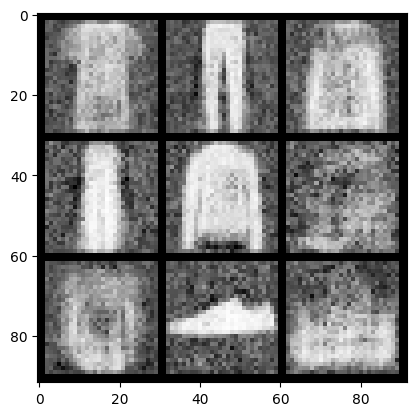

Starting epoch 18...
g_loss: 1.0362122058868408, d_loss: 0.9612383246421814


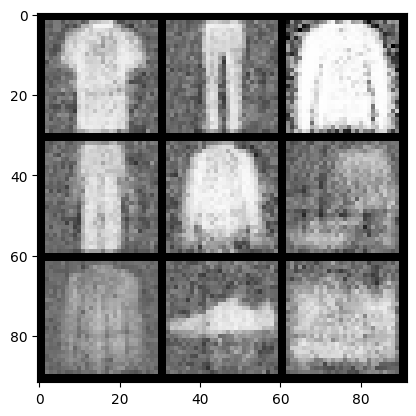

Starting epoch 19...
g_loss: 1.1610689163208008, d_loss: 1.2179644107818604


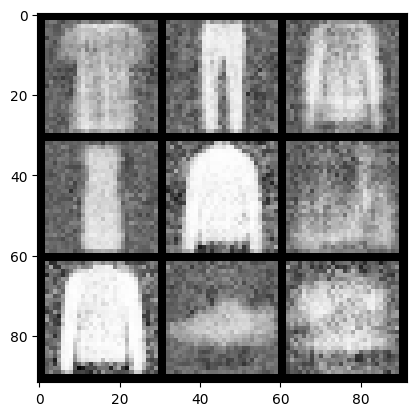

Starting epoch 20...
g_loss: 1.3928338289260864, d_loss: 0.9554799795150757


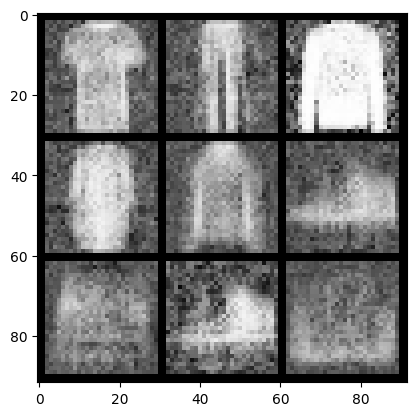

Starting epoch 21...
g_loss: 1.4688942432403564, d_loss: 0.8452258706092834


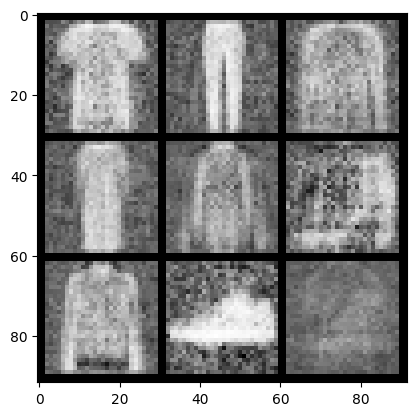

Starting epoch 22...
g_loss: 1.2167816162109375, d_loss: 0.798271656036377


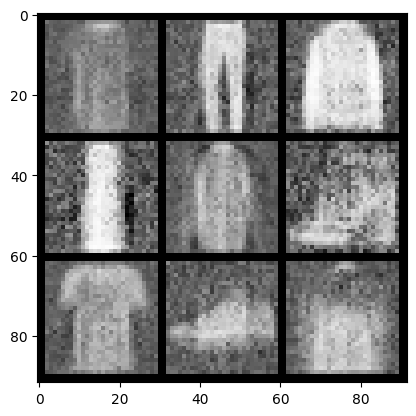

Starting epoch 23...
g_loss: 1.0374624729156494, d_loss: 1.0711555480957031


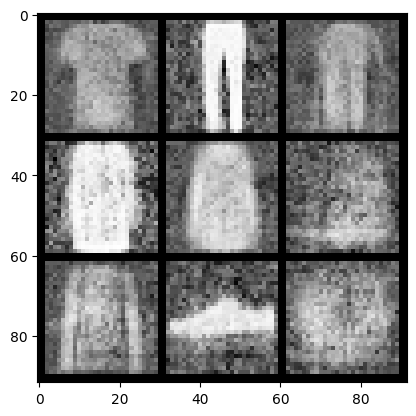

Starting epoch 24...
g_loss: 1.3754637241363525, d_loss: 0.9348923563957214


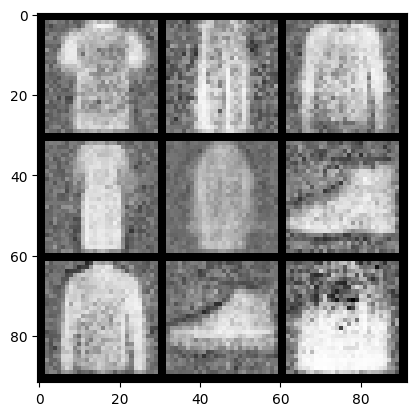

Starting epoch 25...
g_loss: 1.3222990036010742, d_loss: 1.080281376838684


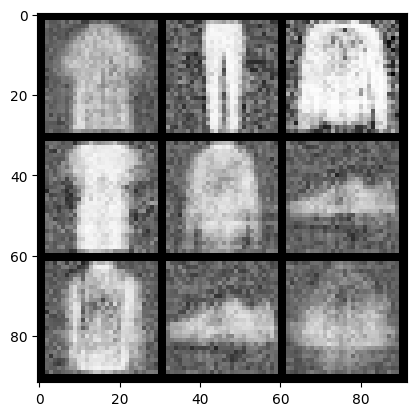

Starting epoch 26...
g_loss: 1.5007596015930176, d_loss: 1.028449296951294


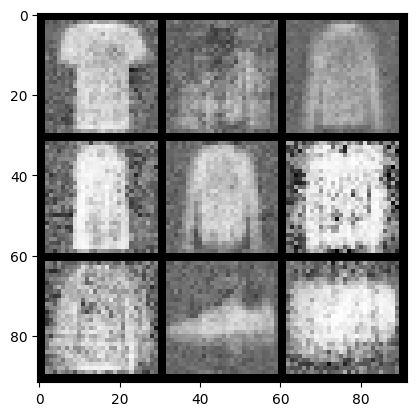

Starting epoch 27...
g_loss: 1.6676948070526123, d_loss: 1.0526092052459717


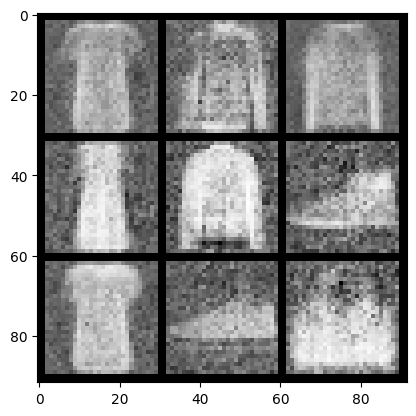

Starting epoch 28...
g_loss: 1.3422808647155762, d_loss: 0.9997862577438354


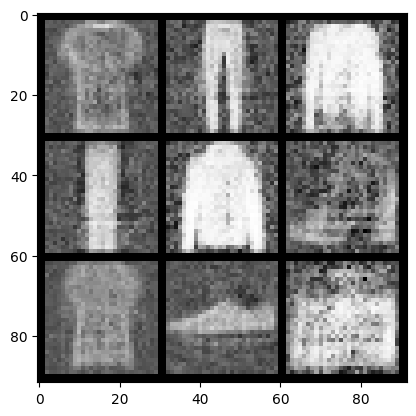

Starting epoch 29...
g_loss: 1.5323787927627563, d_loss: 0.753027081489563


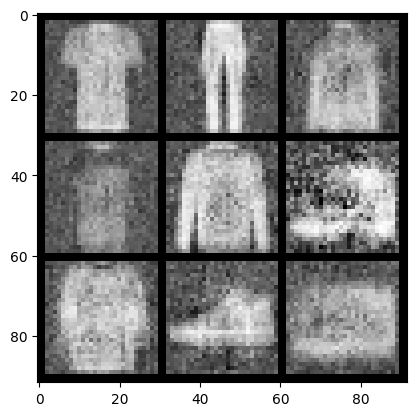

In [16]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()